# Map of Barcelona signatories 

In [15]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [5]:
# URL to the markdown file
url = 'https://raw.githubusercontent.com/cameronneylon/barcelona-declaration-website/main/content/signatories.md'

# Fetch the markdown content from the URL
response = requests.get(url)
md_content = response.text

# Function to parse the markdown lists
def parse_md(md_content):
    groups = re.findall(r'\*\*(.+?)\*\*\n((?:\* .+?\n)+)', md_content)
    data = []

    for group_name, institutions in groups:
        institution_entries = re.findall(r'\* (.+?) \((.+?)\)', institutions)
        for institution, country in institution_entries:
            data.append([institution, country, group_name])

    return pd.DataFrame(data, columns=["institution", "country", "group"])


In [6]:
# Parse the lists in a df and display the first few lines for testing
df = parse_md(md_content)
df.head()

,institution,country,group
0,Aix-Marseille Université,France,Universities and other research performing org...
1,Athena Research Center,Greece,Universities and other research performing org...
2,Charles University,Czech Republic,Universities and other research performing org...
3,Coimbra Group,international,Universities and other research performing org...
4,Delft University of Technology,Netherlands,Universities and other research performing org...


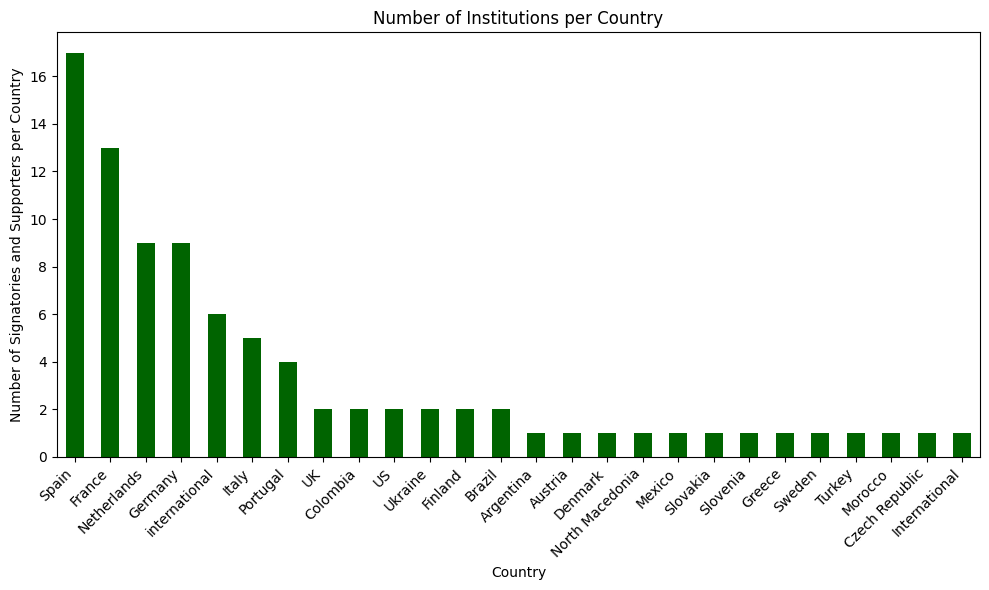

In [30]:
# Count institutions per country
country_counts = df['country'].value_counts()

# Plot barchart
plt.figure(figsize=(10,6))
country_counts.plot(kind='bar', color='darkgreen')

plt.title('Number of Institutions per Country')
plt.xlabel('Country')
plt.ylabel('Number of Signatories and Supporters per Country')
plt.xticks(rotation=45, ha='right')

# Display the barchart
plt.tight_layout()
plt.show()

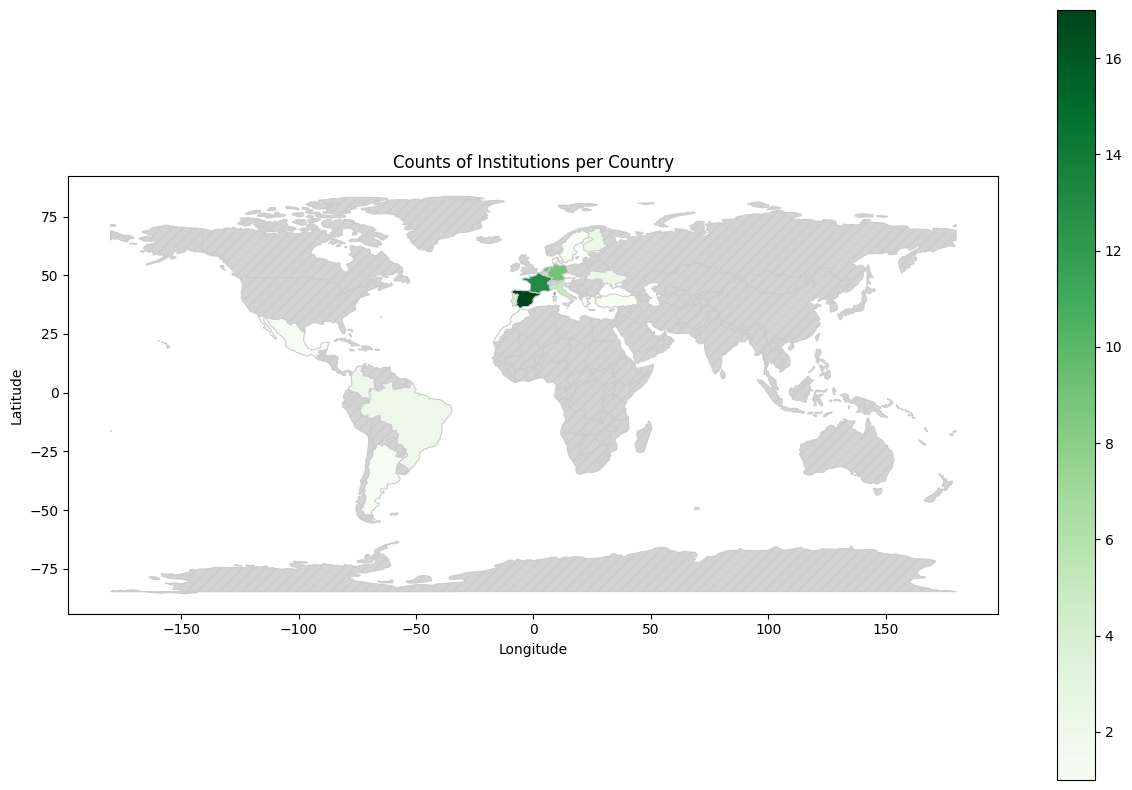

In [37]:
# Load map, thanks to https://github.com/johan for providing this! Finding a working map for geopandas was not easy.
url = 'https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json'
world = gpd.read_file(url)

# Merge the world GeoDataFrame with the institution counts
world_data = world.merge(country_counts, how='left', left_on='name', right_on='country')

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the map with color representing the number of institutions (choropleth)
world_data.plot(
    column='count',
    cmap='Greens',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    missing_kwds={
        'color': 'lightgrey',  # Color for countries with no data
        'edgecolor': '0.8',
        'hatch': '///',  # Optional hatch pattern
        'label': 'No data'  # Label for the legend
    }
)

# Customize the plot
plt.title('Counts of Institutions per Country')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the map
plt.show()


In [ ]:

# Load the Natural Earth dataset for the continents. This can be done in a more elegant way, I am sure. This will be deprecated in Geopandas 1.0, so I need to find a better way.
natural_earth = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [41]:

# Merge df with natural_earth to get continent data
continent_data = natural_earth[['name', 'continent']].rename(columns={'name': 'country'})
df_with_continent = df.merge(continent_data, how='left', on='country')

# Display the resulting DataFrame to check if continent data was merged correctly
print(df_with_continent)

# Now group by continent and count the number of institutions
continent_summary = df_with_continent.groupby('continent')['institution'].count().reset_index()

# Rename columns for clarity
continent_summary.columns = ['continent', 'institution_count']

# Display the summary
print(continent_summary)

                                          institution         country  \
0                            Aix-Marseille Université          France   
1                              Athena Research Center          Greece   
2                                  Charles University  Czech Republic   
3                                       Coimbra Group   international   
4                      Delft University of Technology     Netherlands   
..                                                ...             ...   
83                                   Sage Bionetworks              US   
84  State Scientific and Technical Library of Ukraine         Ukraine   
85  TIB - Leibniz Information Centre for Science a...         Germany   
86                  UK Reproducibility Network - UKRN              UK   
87  West and Central African Research and Educatio...   International   

                                                group  \
0   Universities and other research performing org...   
1   Unive

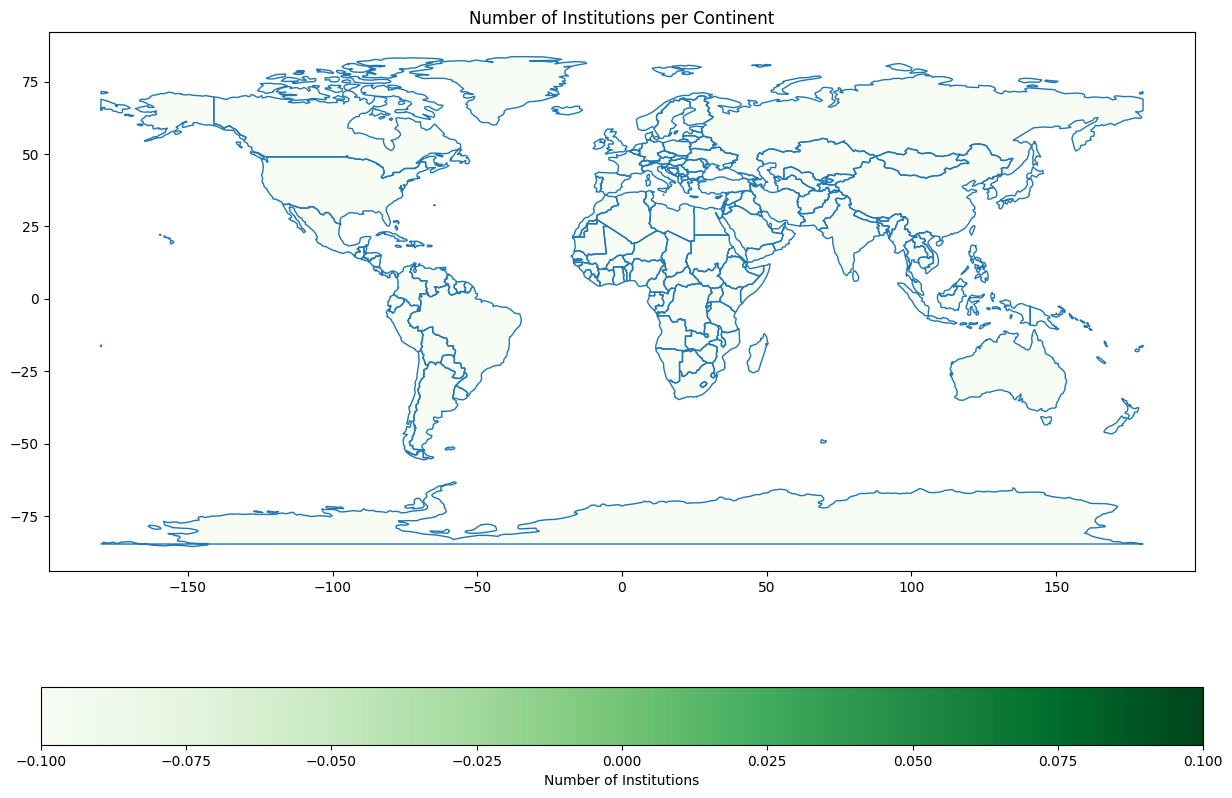

In [47]:
continent_counts = continent_summary.set_index('continent')['institution_count'].to_dict()

# Add institution count data to the world GeoDataFrame
world['institution_count'] = world['name'].map(lambda x: continent_counts.get(x, 0))

# Plotting the  map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='institution_count', ax=ax, legend=True,
           legend_kwds={'label': "Number of Institutions",
                        'orientation': "horizontal"},
           cmap='Greens', missing_kwds={"color": "lightgrey", "label": "No data"})

plt.title('Number of Institutions per Continent')
plt.show()


In [46]:
print(continent_summary)

       continent  institution_count
0         Africa                  1
1           Asia                  1
2         Europe                 68
3  North America                  1
4  South America                  5
